In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


In [0]:
url = 'https://raw.githubusercontent.com/WianStipp/LSTM-For-Price-Prediction/master/data/ETHEUR.csv'
dataframe = pd.read_csv(url, header=None, index_col=0)

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
dataframe.shape

(21703, 1)

In [0]:
dataframe.head()

,1
0,
2017-05-30 23:00:00,196.50
2017-05-31 00:00:00,201.49
2017-05-31 01:00:00,206.11
2017-05-31 02:00:00,207.09
2017-05-31 03:00:00,205.50


In [0]:
dataframe = dataframe.rename(columns = {1:"open"})
dataframe['datetime'] = pd.to_datetime(dataframe.index)
dataframe = dataframe.set_index('datetime')

In [0]:
dataframe.head()

,open
datetime,
2017-05-30 23:00:00,196.50
2017-05-31 00:00:00,201.49
2017-05-31 01:00:00,206.11
2017-05-31 02:00:00,207.09
2017-05-31 03:00:00,205.50


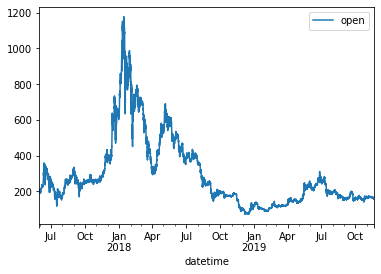

In [0]:
dataframe.plot()

,open
datetime,
2017-05-31 00:00:00,0.025394
2017-05-31 01:00:00,0.022929
2017-05-31 02:00:00,0.004755
2017-05-31 03:00:00,-0.007678
2017-05-31 04:00:00,0.000535


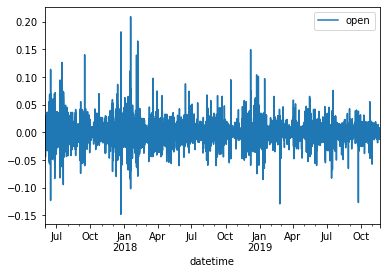

In [0]:
dataframe_pct = (dataframe /dataframe.shift(1) - 1)
dataframe_pct = dataframe_pct.dropna()
dataframe_pct.plot()

dataframe_pct.head()

In [0]:

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [0]:
TRAIN_SPLIT = dataframe_pct.shape[0] * 0.9
TRAIN_SPLIT = round(TRAIN_SPLIT)
print(TRAIN_SPLIT)

19532


In [0]:
tf.random.set_seed(13)

In [0]:
data = dataframe_pct.values

In [0]:
past_history = 40
future_target = 0

X_train , y_train = univariate_data(data, 0, TRAIN_SPLIT, past_history, future_target)

X_val, y_val = univariate_data(data, TRAIN_SPLIT, None, past_history, future_target)



In [0]:
print(X_train.shape,"<- X, Y-> ", y_train.shape)


(19492, 40, 1) <- X, Y->  (19492, 1)


In [0]:
print(X_train[0])

[[ 2.53944020e-02]
 [ 2.29291776e-02]
 [ 4.75474261e-03]
 [-7.67782124e-03]
 [ 5.35279805e-04]
 [-5.34993434e-04]
 [-2.67639903e-02]
 [-2.06500000e-02]
 [ 1.08745597e-02]
 [ 1.42929293e-02]
 [ 1.74276751e-03]
 [ 3.08181728e-03]
 [-4.95540139e-04]
 [ 3.05404065e-02]
 [-1.36149331e-02]
 [ 1.19006975e-02]
 [-4.19337736e-03]
 [-2.22168441e-02]
 [-7.57388248e-03]
 [-4.88826816e-03]
 [ 3.95989975e-03]
 [ 1.70752409e-02]
 [ 7.85430269e-04]
 [-1.81488203e-03]
 [ 7.37100737e-03]
 [-4.04878049e-03]
 [-4.89787922e-05]
 [ 2.35109718e-03]
 [ 1.37314308e-02]
 [ 5.68811762e-03]
 [-4.93696976e-03]
 [ 1.92678227e-03]
 [ 1.44230769e-02]
 [-1.89099526e-02]
 [-4.83068451e-04]
 [-4.34971727e-03]
 [ 1.30576186e-02]
 [-1.22664111e-02]
 [-5.48171146e-03]
 [-2.48768353e-03]]


In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)

  return time_steps

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  plt.show()
  return plt

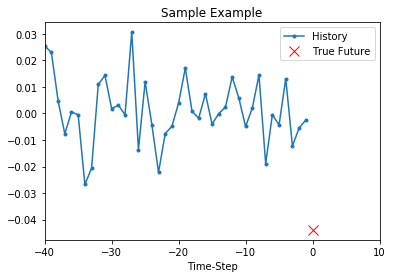

In [0]:
show_plot([X_train[0], y_train[0]], 0, 'Sample Example')
plt.show()

In [0]:
def baseline(history):
  return np.mean(history)

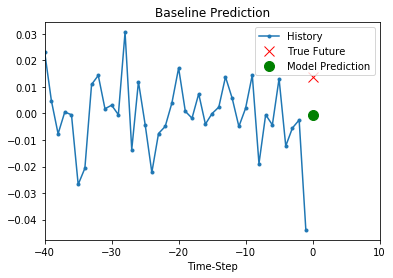

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [0]:
show_plot([X_train[1], y_train[1], baseline(X_train[1])], 0 ,'Baseline Prediction')

In [0]:
BATCH_SIZE = 512
BUFFER_SIZE = 10000

train_tensor = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_tensor = train_tensor.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_tensor = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_tensor = val_tensor.batch(BATCH_SIZE).repeat()

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, input_shape=X_train.shape[-2:], return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(100, input_shape = X_train.shape[-2:], return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer = 'Nadam', loss ='mae')

In [0]:
simple_lstm_model.reset_states()

In [0]:
for x, y in val_tensor.take(1):
    print(simple_lstm_model.predict(x).shape)

(512, 1)


In [0]:
EVALUATION_INTERVAL = 8000
EPOCHS = 3 

simple_lstm_model.fit(train_tensor,  epochs = EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_tensor, validation_steps = 50)

Train for 8000 steps, validate for 50 steps
Epoch 1/3
8000/8000 [==============================] - 102s 13ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 2/3
8000/8000 [==============================] - 100s 12ms/step - loss: 0.0074 - val_loss: 0.0041
Epoch 3/3
8000/8000 [==============================] - 99s 12ms/step - loss: 0.0074 - val_loss: 0.0042


In [0]:
simple_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 40, 50)            10400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
val_dataframe = dataframe[TRAIN_SPLIT:]
val_dataframe_pct = val_dataframe.pct_change()[1:]
val_dataframe = val_dataframe[1:]
val_dataframe_CHECK = val_dataframe

In [0]:
val_dataframe_CHECK.head()

,open
datetime,
2019-08-22 20:00:00,175.00
2019-08-22 21:00:00,173.44
2019-08-22 22:00:00,173.76
2019-08-22 23:00:00,173.64
2019-08-23 00:00:00,175.16


In [0]:
val_dataframe_CHECK.shape

(2170, 1)

In [0]:
simple_lstm_model.predict(val_dataframe_pct["open"].values[0:0+40].reshape(1,40,1))[0][0]


0.0009121115

In [0]:
np.count_nonzero(val_dataframe_CHECK.index != val_dataframe_pct.index)


0

In [0]:
val_dataframe_CHECK.index[0]

Timestamp('2019-08-22 20:00:00')

In [0]:
total_return = []
prediction = []
account_size = 10000

for i in range(val_dataframe_CHECK.shape[0] - 41):
  risk = 0.01* account_size

  if i == 0:
    print(val_dataframe_CHECK.index[0])
  if i == val_dataframe_CHECK.shape[0] - 41:
    print(val_dataframe_CHECK.index[val_dataframe_CHECK.shape[0] - 41])

  if np.abs(simple_lstm_model(val_dataframe_pct['open'].values[i:i+40].reshape(1,40,1))[0][0]) > 0.001:
    model_prediction = (simple_lstm_model.predict(val_dataframe_pct['open'].values[i:i+40].reshape(1,40,1))[0][0] +1)*val_dataframe_CHECK.values[i+40]
